In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
import datetime

plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


### 定义函数

In [104]:
def get_season(month):
    """
    根据月份添加季节字段
    :param month:
    :return:
    """

    if 3 <= month <= 5:
        return "Spring"
    elif 6 <= month <= 8:
        return "Summer"
    elif 9 <= month <= 11:
        return "Autumn"
    else:
        return "Winter"
def calculate_error(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    # return U95
    return {
        "R": round(R, 3),
        "MBE": round(MBE, 3),
        # "%MBE": MBE_percent,
        "RMSE": round(RMSE, 3),
        # "%RMSE": RMSE_percent,
        "U95": round(U95, 3)
    }

### 数据准备及误差计算

In [112]:
# 产品列名
product_column = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA2', 'SSP245', 'SSP585']

# 读取2000~2018年的数据
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation'})
database = database[
(database["date"] >= datetime.date(2000, 1, 1)) &
(database["date"] <= datetime.date(2018, 12, 31))
]
# 添加 year、month字段
database["year"] = database["date"].apply(lambda x: x.year)
database["month"] = database["date"].apply(lambda x: x.month)
database["season"] = database["month"].apply(get_season)
# 移除无关列
database.drop(columns=["originalID", "stationIndex", "date", "lat", "lon", "month"], inplace=True)
# Phase Ⅰ 2000~2009
phaseOne = database[(database["year"] >= 2000) & (database["year"] <= 2009)]
# Phase Ⅱ 2010~2018
phaseTwo = database[(database["year"] >= 2010) & (database["year"] <= 2018)]

In [113]:

for i, phase in enumerate([phaseOne, phaseTwo]):
    print(f"****************************************Phase {i+1}****************************************")
    for product in product_column:
        # 分离产品数据
        product_data = phase[~phase[product].isna()][["season", "Observation", product]].rename(columns={product:"Model"}) .reset_index(drop=True)
        # 按season分组计算 R RMSE MBE U95
        error_dict = product_data.groupby("season").apply(lambda x: calculate_error(x["Observation"], x["Model"]), include_groups=False)
        # 将字典转换为 DataFrame
        error = pd.DataFrame(error_dict.tolist(), index=error_dict.index)
        print(f"\n-------Production {product}-------")
        print(error)

# 手动保存到excel中 👇

****************************************Phase 1****************************************

-------Production ISCCP-ITP-------
           R    MBE   RMSE    U95
season                           
Autumn 0.957  -1.77 24.431 15.972
Spring 0.927 -4.023 30.834 14.082
Summer 0.903  2.197 32.106 12.872
Winter 0.955 -4.743 22.896 19.832

-------Production GLASS-------
           R    MBE   RMSE    U95
season                           
Autumn 0.948 -3.038 23.747 15.219
Spring 0.891 -3.738 33.741  15.01
Summer 0.857  2.959 34.236 13.488
Winter 0.935 -1.225 23.785 19.019

-------Production ERA5-------
           R    MBE   RMSE    U95
season                           
Autumn 0.959  2.958 23.282 15.551
Spring 0.928  6.194 28.918 13.484
Summer 0.907 -2.429 28.681  11.66
Winter 0.969  7.534 19.823 19.128

-------Production MERRA2-------
           R    MBE   RMSE    U95
season                           
Autumn  0.95 10.665 28.371 19.773
Spring 0.911  7.769 34.781 15.919
Summer 0.875   10.9 38.332  15.5

### 绘制棒棒糖图

In [35]:
# 生成示例数据
# np.random.seed(42)
num_production = 6
num_groups = 4
phases = [1, 2]

# data = {
#     'Model': [],
#     'Group': [],
#     'Year': [],
#     'Value': []
# }
#
# for model in range(1, num_production + 1):
#     for group in range(1, num_groups + 1):
#         for year in phases:
#             value = np.random.randint(10, 100)
#             data['Model'].append(f'Model {model}')
#             data['Group'].append(group)
#             data['Year'].append(year)
#             data['Value'].append(value)
#
# df_test = pd.DataFrame(data)

# 读取整理的excel数据
df = pd.read_excel(r"D:\PhD\UCAS\Undergraduate\Projects\Python\datas\10按季节-棒棒糖图.xlsx")

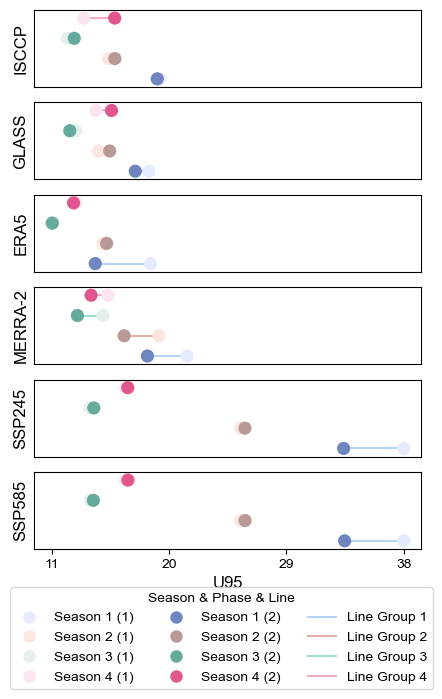

In [100]:
# 定义颜色映射，为不同年份和组生成颜色
phase_colors = {
    1: ['#e7ebff', '#fde6df', '#e6f0ea', '#fde4f1'], # 浅色
    2: ['#6f85bf', '#b99996', '#65ab9d', '#e1568e']  # 深色
}

# 定义每组直线的颜色
line_colors = ['#b6d4f5', '#e0b0a9', '#9edbce', '#f2adc2'] # 中间色

# 指标列名
error_name = "U95"
# 定义期望的 Model 顺序
desired_production_order = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
# 定义期望的 Season 顺序（用于下方的柱状图）
desired_season_order = [4, 3, 2, 1]

# vmin = np.percentile(df[error_name], 5)
# vmax = np.percentile(df[error_name], 95)
vmin = df[error_name].min()
vmax = df[error_name].max()


# 创建一个包含 6 个子图的图形，共用 x 轴
fig, axes = plt.subplots(num_production, 1, sharex=True, figsize=(5, 7))

# 调整组之间的间距因子
spacing_factor = 0.5
# 遍历每个模型绘制棒棒糖图
for i, production_name in enumerate(desired_production_order):
    model_data = df[df['Production'] == production_name]
    ax = axes[i]
    for group, group_data in model_data.groupby('Season'):
        group_data = group_data.sort_values(by='Phase')
        x_values = group_data[error_name].tolist()
        y_values = [(group - 1) * spacing_factor] * len(group_data)
        # y_values = [group] * len(group_data)
        phase_values = group_data['Phase'].tolist()

        # 绘制两点之间的线段，使用对应组的颜色
        line_color = line_colors[group - 1]
        if len(x_values) > 1:
            ax.plot(x_values, y_values, color=line_color, linestyle='-')

        # 绘制点，根据组和年份设置颜色
        for j in range(len(x_values)):
            phase = phase_values[j]
            color = phase_colors[phase][group - 1]
            ax.scatter(x_values[j], y_values[j], s=3**2 * 10, edgecolor='none',
                       facecolor=color, marker='o', zorder=10)

    # 设置轴刻度和标签
    # ax.set_yticks([(g - 1) * spacing_factor for g in range(1, num_groups + 1)])
    # ax.set_yticklabels([f'Season {g}' for g in range(1, num_groups + 1)])


    ax.set_yticks([]) # 隐藏Y轴刻度
    # 设置Y轴标签
    ax.set_ylabel(production_name, fontsize=12, color='black')
    # ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    x_ticks = np.linspace(vmin, vmax, 4)
    ax.set_xticks(x_ticks)
    # ax.set_xticklabels([f'{t:.2f}' for t in x_ticks], fontsize=10) # 保留两位小数
    ax.set_xticklabels([f'{int(t)}' for t in x_ticks], fontsize=10)

    # 调整 x 轴和 y 轴的边界以避免点被遮挡
    y_min = -0.2
    y_max = 1.7
    ax.set_ylim(y_min, y_max)

    if i < num_production - 1:
        ax.axes.xaxis.set_visible(False)


# 设置共享的 x 轴标签
axes[-1].set_xlabel(error_name, fontsize=12)

# 添加图例
legend_elements = []
for phase in phases:
    for group in range(1, num_groups + 1):
        color = phase_colors[phase][group - 1]
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w',
                       label=f'Season {group} ({phase})',
                       markerfacecolor=color, markersize=10)
        )

# 添加直线颜色的图例
for group in range(1, num_groups + 1):
    line_color = line_colors[group - 1]
    legend_elements.append(
        plt.Line2D([0], [1], color=line_color, linestyle='-', label=f'Line Group {group}')
    )

fig.legend(handles=legend_elements, title='Season & Phase & Line', fontsize=10, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))


# 保存为矢量
# fig.savefig('figs/10-4棒棒糖图-U95.pdf', format='pdf', dpi=1000, bbox_inches='tight')
# 显示图形
plt.show()

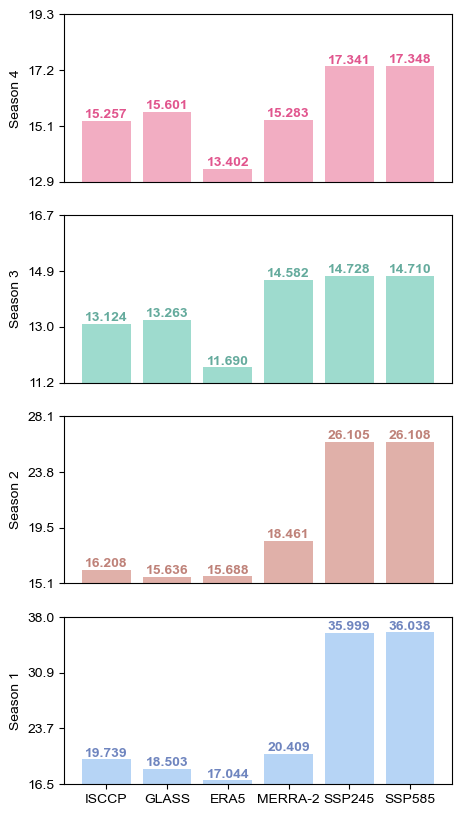

In [103]:
# 计算每个模型在两个阶段下两年（阶段）的平均值
grouped_df = df.groupby(['Production', 'Season'])[error_name].mean().reset_index()

# 按照自定义顺序对产品进行排序（X轴）
grouped_df["Production"] = pd.Categorical(grouped_df["Production"], categories=desired_production_order, ordered=True)
grouped_df = grouped_df.sort_values(by="Production")
# 按照自定义顺序对季节进行排序（绘制顺序）
grouped_df["Season"] = pd.Categorical(grouped_df["Season"], categories=desired_season_order, ordered=True)
grouped_df = grouped_df.sort_values(by="Season")
# 再次按Production排序，确保Production顺序正确
grouped_df = grouped_df.sort_values(by="Production")

# 定义颜色
colors_bar = ['#f2adc2', '#9edbce', '#e0b0a9', '#b6d4f5'] # 中色
colors_txt = ["#e1568e", "#65ab9d", "#bf8279", "#6f85bf"] # 深色
# colors_txt = ["#fde4f1", "#e6f0ea", "#fde6df", "#e7eafe"] # 浅色

# 创建一个包含4个子图的图形，位于同一列
# fig, axes = plt.subplots(num_groups, 1, figsize=(8, 12))
fig, axes = plt.subplots(num_groups, 1, figsize=(5, 10))

for i, season in enumerate(desired_season_order):
    season_data = grouped_df[grouped_df['Season'] == season]
    model_names = season_data['Production']
    avg_values = season_data[error_name]

    axes[i].bar(model_names, avg_values, color=colors_bar[i])
    hmin = np.min(avg_values)-0.5
    hmax = np.max(avg_values)+2
    y_ticks = np.linspace(hmin, hmax, 4)
    axes[i].set_ylim(hmin, hmax)
    axes[i].set_yticks(y_ticks)
    axes[i].set_yticklabels([f'{t:.1f}' for t in y_ticks], fontsize=10)
    axes[i].set_ylabel(f'Season {season}')

    if i< num_groups-1:
        axes[i].axes.xaxis.set_visible(False)


     # 添加值标签
    for j, value in enumerate(avg_values):
        axes[i].text(j, value, f'{value:.3f}', ha='center', va='bottom', color=colors_txt[i], fontweight="bold")


# 保存为矢量
fig.savefig('figs/10-4柱状图-U95.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
